# Credit Card Fraud Detection

Throughout the financial sector, machine learning algorithms are being developed to detect fraudulent transactions. In this project, that is exactly what we are going to be doing as well. Using a dataset of of nearly 28,500 credit card transactions and multiple unsupervised anomaly detection algorithms, we are going to identify transactions with a high probability of being credit card fraud. In this project, we will build and deploy the following two machine learning algorithms:

* Local Outlier Factor (LOF)
* Isolation Forest Algorithm

Furthermore, using metrics suchs as precision, recall, and F1-scores, we will investigate why the classification accuracy for these algorithms can be misleading.

In addition, we will explore the use of data visualization techniques common in data science, such as parameter histograms and correlation matrices, to gain a better understanding of the underlying distribution of data in our data set. Let's get started!

# Importing Necessary Libraries
To start, let's print out the version numbers of all the libraries we will be using in this project. This serves two purposes - it ensures we have installed the libraries correctly and ensures that this tutorial will be reproducible.

In [24]:
import sys
import numpy
import pandas
import matplotlib
import seaborn
import scipy

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(numpy.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Seaborn: {}'.format(seaborn.__version__))
print('Scipy: {}'.format(scipy.__version__))

Python: 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Numpy: 1.18.5
Pandas: 1.0.5
Matplotlib: 3.2.2
Seaborn: 0.10.1
Scipy: 1.5.0


In [40]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. The Data Set

In the following cells, we will import our dataset from a .csv file as a Pandas DataFrame. Furthermore, we will begin exploring the dataset to gain an understanding of the type, quantity, and distribution of data in our dataset. For this purpose, we will use Pandas' built-in describe feature, as well as parameter histograms and a correlation matrix.

In [26]:
#Load the dataset from the csv file
data = pd.read_csv('creditcard.csv')

In [27]:
# explore the dataset
print(data.columns)
print(data.shape)

# V1 - V28 are the results of a PCA Dimensionality reduction to protect 
#user identities and sensitive features

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
(284807, 31)


In [28]:
print(data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [29]:
#Sampling data to save time and computations

data = data.sample(frac = 0.0983121903605, random_state = 1)

print(data.shape)

(28000, 31)


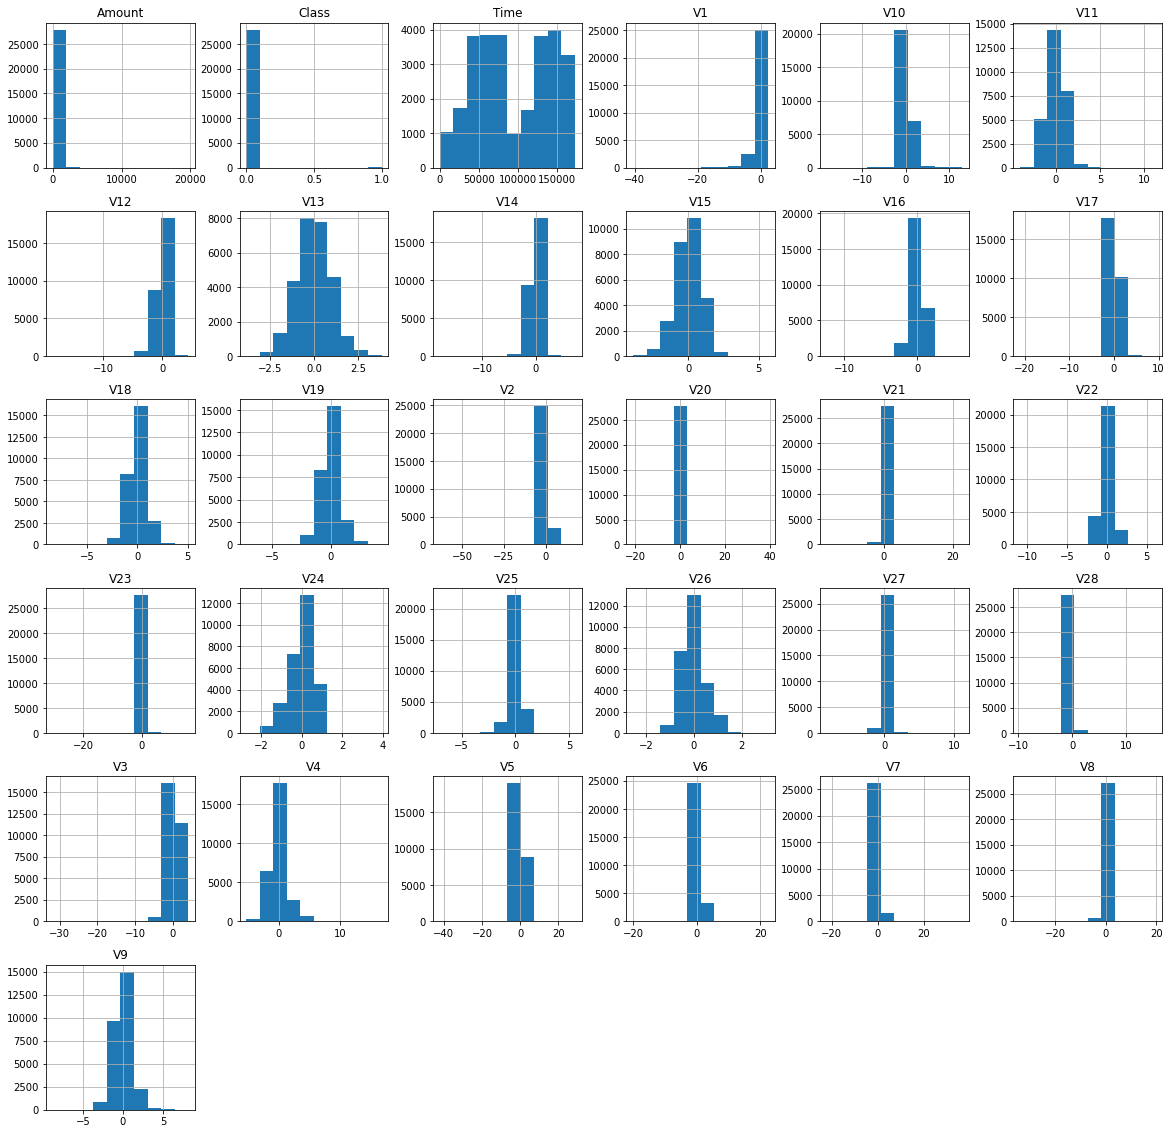

In [30]:
#Plot a histogram of each parameter
data.hist(figsize = (20, 20))
plt.show()

In [31]:
# Detemine number of fraud and valid cases in dataset
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

outlier_fraction = len(fraud) / float(len(valid)) #Since its really low.... not using a float would round it to zero
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Cases: {}'.format(len(valid)))

0.001753067868770348
Fraud Cases: 49
Valid Cases: 27951


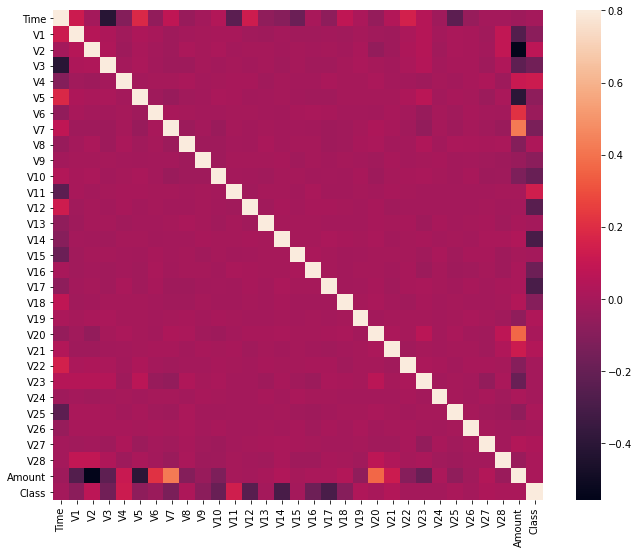

In [33]:
# Correlation Matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [41]:
# Get all the columns from the dataframe
columns = data.columns.tolist()

#Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ['Class']]

#Store the variable we'll be predicting on
target = 'Class'

X = data[columns]
Y = data[target]

#print the shapes of x and y
print(X.shape)
print(Y.shape)

(28000, 30)
(28000,)


# 3. Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms. We will use the following techniques:

## Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood.

## Isolation Forest Algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [35]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples = len(X),
                                        contamination = outlier_fraction,
                                        random_state = 1),
    
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20,
                                                contamination=outlier_fraction)
}

In [39]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

Isolation Forest: 71
0.9974642857142857
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27951
           1       0.28      0.29      0.28        49

    accuracy                           1.00     28000
   macro avg       0.64      0.64      0.64     28000
weighted avg       1.00      1.00      1.00     28000

Local Outlier Factor: 97
0.9965357142857143
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27951
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28000
   macro avg       0.51      0.51      0.51     28000
weighted avg       1.00      1.00      1.00     28000



<Figure size 648x504 with 0 Axes>